In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-25a8cdbf-56c0-521b-b855-e8cd1f848fa1"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from hydra.utils import instantiate
from PIL import Image
from torch.utils.data import DataLoader, Dataset

from br.models.compute_features import get_embeddings
from br.models.load_models import get_data_and_models
from br.models.save_embeddings import get_pc_loss, save_embeddings
from br.models.utils import get_all_configs_per_dataset

device = "cuda:0"

# Load cellprofiler embeddings 

In [5]:
all_ret = pd.read_csv('/allen/aics/modeling/ritvik/projects/second_clones/benchmarking_representations/npm1_perturb/cellprofiler_3d_features_connectivity_fix_pixel_spacing.csv')
tmp = pd.read_csv('/allen/aics/modeling/ritvik/projects/second_clones/benchmarking_representations/npm1_perturb/cellprofiler_3d_features_connectivity_fix_pixel_spacing.csv')
orig_df = pd.read_csv("/allen/aics/modeling/ritvik/projects/aws_uploads/NPM1_single_cell_drug_perturbations/manifest.csv")
all_ret = all_ret.merge(orig_df, on='CellId')
cellprofiler_cols = [i for i in tmp.columns if "Mean" in i or "StDev" in i or "Median" in i]
all_ret['model'] = 'cellprofiler'
all_ret["well_position"] = "A0"  # dummy
all_ret["Assay_Plate_Barcode"] = "Plate0"  # dummy

0                       Torin 1uM
1             Rotenone 0.5uM (E6)
2           Roscovitine 10uM (E9)
3                  DMSO (control)
4                 Chloroquin 40uM
                  ...            
1020    Jasplakinolide 50 nM (E5)
1021          Paclitaxel 5uM (E2)
1022        Nocodazole 0.1uM (E4)
1023                    Torin 1uM
1024       Staurosporine 1uM (E8)
Name: condition, Length: 1025, dtype: object

# Compute q values

In [8]:
# Compute mAP and fraction retrieved as described in Chandrasekaran 2024
import pandas as pd
from tqdm import tqdm
import pycytominer
from br.chandrasekaran_et_al import utils


def get_featurecols(df):
    """returna  list of featuredata columns"""
    # return [c for c in df.columns if "mu_" in c]
    return cellprofiler_cols


def get_featuredata(df):
    """return dataframe of just featuredata columns"""
    return df[get_featurecols(df)]


# cols = [i for i in all_ret.columns if "mu_" in i]
cols = cellprofiler_cols

replicate_feature = "Metadata_broad_sample"
batch_size = 100000
null_size = 100000


all_rep = []
all_match = []
all_fr = []
for model in tqdm(all_ret["model"].unique(), total=len(all_ret["model"].unique())):
    df_feats = all_ret.loc[all_ret["model"] == model].reset_index(drop=True)
    df_feats["Metadata_ObjectNumber"] = df_feats["CellId"]

    all_normalized_df = []
    # cols = [i for i in df_feats.columns if "mu_" in i]
    cols = cellprofiler_cols
    for plate in df_feats["Assay_Plate_Barcode"].unique():
        test = df_feats.loc[df_feats["Assay_Plate_Barcode"] == plate].reset_index(drop=True)
        # test = test.groupby(['condition_coarse']).mean().reset_index()
        # test['Assay_Plate_Barcode'] = 'plate0'
        # test['well_position'] = 'a0'
        print(len(cols))
        normalized_df = pycytominer.normalize(
            profiles=test,
            features=cols,
            meta_features=[
                "Assay_Plate_Barcode",
                "well_position",
                "condition_coarse",
                "condition",
            ],
            method="standardize",
            mad_robustize_epsilon=0,
            samples="all",
        )
        normalized_df = pycytominer.normalize(
            profiles=normalized_df,
            features=cols,
            meta_features=[
                "Assay_Plate_Barcode",
                "well_position",
                "condition_coarse",
                "condition",
            ],
            method="standardize",
            samples="condition == 'DMSO (control)'",
        )

        all_normalized_df.append(normalized_df)
    df_final = pd.concat(all_normalized_df, axis=0).reset_index(drop=True)

    vals = []
    for ind, row in df_final.iterrows():
        if row["condition"] == "DMSO (control)":
            vals.append("negcon")
        else:
            vals.append(None)

    # more dummy cols
    df_final["Metadata_control_type"] = vals
    df_final["Metadata_broad_sample"] = df_final["condition"]
    df_final["Cell_type"] = "hIPSc"
    df_final["Perturbation"] = "compound"
    df_final["Time"] = "1"
    df_final["Metadata_target_list"] = "none"
    df_final["target_list"] = "none"
    df_final["Metadata_Plate"] = "Plate0"

    experiment_df = df_final

    replicability_map_df = pd.DataFrame()
    replicability_fr_df = pd.DataFrame()
    matching_map_df = pd.DataFrame()
    matching_fr_df = pd.DataFrame()
    gene_compound_matching_map_df = pd.DataFrame()
    gene_compound_matching_fr_df = pd.DataFrame()

    replicate_feature = "Metadata_broad_sample"
    for cell in experiment_df.Cell_type.unique():
        cell_df = experiment_df.query("Cell_type==@cell")
        modality_1_perturbation = "compound"
        modality_1_experiments_df = cell_df.query("Perturbation==@modality_1_perturbation")
        for modality_1_timepoint in modality_1_experiments_df.Time.unique():
            modality_1_timepoint_df = modality_1_experiments_df.query(
                "Time==@modality_1_timepoint"
            )
            modality_1_df = pd.DataFrame()
            for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
                data_df = df_final.loc[df_final["Assay_Plate_Barcode"].isin([plate])]
                data_df = data_df.drop(
                    columns=["Metadata_target_list", "target_list"]
                ).reset_index(drop=True)
                # data_df = data_df.groupby(['pert_iname']).sample(n=10).reset_index(drop=True)
                modality_1_df = utils.concat_profiles(modality_1_df, data_df)

            # Set Metadata_broad_sample value to "DMSO" for DMSO wells
            modality_1_df[replicate_feature].fillna("DMSO", inplace=True)
            print(modality_1_df.shape)

            # Remove empty wells
            modality_1_df = utils.remove_empty_wells(modality_1_df)

            # Description
            description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}"

            modality_1_df["Metadata_negcon"] = np.where(
                modality_1_df["Metadata_control_type"] == "negcon", 1, 0
            )  # Create dummy column

            pos_sameby = ["Metadata_broad_sample"]
            pos_diffby = []
            neg_sameby = ["Metadata_Plate"]
            neg_diffby = ["Metadata_negcon"]

            metadata_df = utils.get_metadata(modality_1_df)
            feature_df = get_featuredata(modality_1_df)
            feature_values = feature_df.values

            result = utils.run_pipeline(
                metadata_df,
                feature_values,
                pos_sameby,
                pos_diffby,
                neg_sameby,
                neg_diffby,
                anti_match=False,
                batch_size=batch_size,
                null_size=null_size,
            )
            result = result.query("Metadata_negcon==0").reset_index(drop=True)

            qthreshold = 0.001

            replicability_map_df, replicability_fr_df = utils.create_replicability_df(
                replicability_map_df,
                replicability_fr_df,
                result,
                pos_sameby,
                qthreshold,
                modality_1_perturbation,
                cell,
                modality_1_timepoint,
            )
    replicability_map_df["model"] = model
    matching_map_df["model"] = model
    replicability_fr_df["model"] = model
    all_rep.append(replicability_map_df)
    all_match.append(matching_map_df)
    all_fr.append(replicability_fr_df)

  0%|          | 0/1 [00:00<?, ?it/s]

81
(1025, 91)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:15<00:00, 15.53s/it]


In [9]:
all_rep = pd.concat(all_rep, axis=0).reset_index(drop=True)
all_fr = pd.concat(all_fr, axis=0).reset_index(drop=True)

all_fr["metric"] = "Fraction retrieved"
all_fr["value"] = all_fr["fr"]
all_rep["metric"] = "Mean average precision"
all_rep["value"] = all_rep["mean_average_precision"]
metrics = pd.concat([all_fr, all_rep], axis=0).reset_index(drop=True)

plot_df = metrics.loc[metrics["metric"] == "Fraction retrieved"].reset_index(drop=True)

# Add pre-computed q values for other models

In [11]:
all_rep2 = pd.read_csv('/allen/aics/modeling/ritvik/projects/second_clones/benchmarking_representations/npm1_perturb/qvalues_all_models_except_cellprofiler.csv')
all_rep = pd.concat([all_rep, all_rep2], axis=0).reset_index(drop=True)

rep_dict = {'CNN_sdf_noalign_global': 'Classical_image_SDF', 'CNN_sdf_SO3_global': 'SO3_image_SDF', 
           'CNN_seg_noalign_global': 'Classical_image_seg', 'CNN_seg_SO3_global': 'SO3_image_seg', 
           'vn_so3': 'SO3_pointcloud_SDF', 'Rotation_invariant_pointcloud_SDF_npm1': 'SO3_pointcloud_SDF_NPM1'}
all_rep['model'] = all_rep['model'].replace(rep_dict)
this_2 = all_rep.loc[all_rep['model'].isin(['SO3_image_SDF', 'Classical_image_SDF', 'SO3_pointcloud_SDF'])]
ordered_drugs = this_2.groupby(['Metadata_broad_sample']).mean().sort_values(by='q_value').reset_index()['Metadata_broad_sample']

In [14]:
# save location
save_path = '/allen/aics/modeling/ritvik/projects/second_clones/benchmarking_representations/npm1_perturb/'

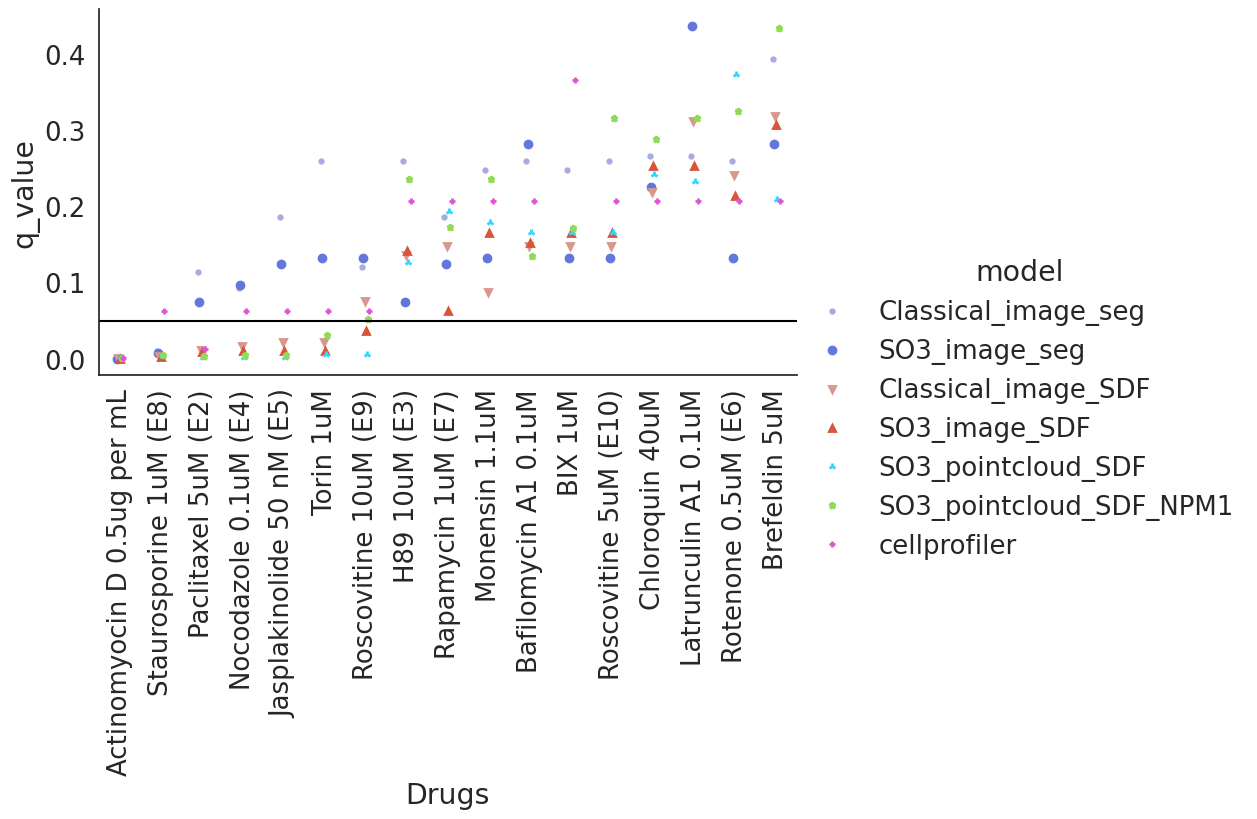

In [15]:
from pathlib import Path

import seaborn as sns

sns.set_context("talk")
sns.set(font_scale=1.7)
sns.set_style("white")

test = all_rep.sort_values(by="q_value").reset_index(drop=True)
test["Drugs"] = test["Metadata_broad_sample"]

x_order = (
    test.loc[test["model"] == "SO3_pointcloud_SDF"]
    .sort_values(by="q_value")["Metadata_broad_sample"]
    .values
)

x_order = ordered_drugs

models = [
        "Classical_image_seg",
        "SO3_image_seg",
        "Classical_image_SDF",
        "SO3_image_SDF",
        "SO3_pointcloud_SDF",
        "SO3_pointcloud_SDF_NPM1",
        "cellprofiler",
    ]

markers = [".", "o", 'v', '^', '2', '*', '+']
marker_dict = {i:j for i, j in zip(models, markers)}
g = sns.catplot(
    data=test,
    x="Drugs",
    y="q_value",
    kind='point',
    hue="model",
    order=x_order,
    hue_order=models,
    palette=["#A6ACE0", "#6277DB", "#D9978E", "#D8553B", "#2ED9FF", "#91db57", '#db57d3'],
    aspect=2,
    height=5,
    dodge=True,
    # dodge=sns.objects.Dodge(width=0.5)
    linestyles='none',
    # markers=marker_dict
    markers=[".", "o", 'v', '^', '2', '*', '+'], 
    markersize=5,
)
g.set_xticklabels(rotation=90)
plt.axhline(y=0.05, color="black")

Path(save_path).mkdir(parents=True, exist_ok=True)
# g.savefig(Path(save_path) / "q_values2.pdf", dpi=300, bbox_inches="tight")
# g.savefig(Path(save_path) / "q_values2.png", dpi=300, bbox_inches="tight")